In [14]:

# coding: utf-8

# In[14]:

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

class TwoPathConv(nn.Module):
    def __init__(self):
        super(TwoPathConv, self).__init__()
        self.local_conv1 = nn.Conv2d(4, 64, 7, padding = 16)
        #self.bn1 = nn.BatchNorm2d(64)
        self.local_conv2 = nn.Conv2d(64, 64, 3)
        #self.bn2 = nn.BatchNorm2d(64)
        self.local_conv3 = nn.Conv2d(4, 160, 13, padding = 16)
        #self.bn3 = nn.BatchNorm2d(160)
        self.total_conv = nn.Conv2d(224, 5, 21)

    def forward(self, x):
        under_x = F.relu(self.local_conv3(x))
        x = self.local_conv1(x)
        #x = self.bn1(x)
        x = F.max_pool2d(F.relu(x), 4, stride = 1)
        x = self.local_conv2(x)
        #x = self.bn2(x)
        x = F.max_pool2d(F.relu(x), 2, stride = 1)
        x = torch.cat((x, under_x), 1)
        x = self.total_conv(x)
        return x


# In[2]:

class TwoPathConv_alter(nn.Module):
    def __init__(self):
        super(TwoPathConv_alter, self).__init__()
        self.upper_layer1 = nn.Sequential(
            nn.Conv2d(9,64,7, padding = 16),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.upper_layer2 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13, padding = 16),
            nn.ReLU()
        )
        self.final_layer = nn.Conv2d(224,5,21)
    def forward(self, x):
        upper_x = self.upper_layer2(self.upper_layer1(x))
        under_x = self.under_layer1(x)
        out = torch.cat((under_x, upper_x), 1)
        return out    
    
class Cascaded(nn.Module):
    def __init__(self, net1, net2):
        super(Cascaded, self).__init__()
        self.twopathconv1 = net1
        self.twopathconv2 = net2
        self.final_layer = nn.Conv2d(224, 5, 21)
    def forward(self, x1, x2):
        upper_x = self.twopathconv1(x1)
        lower_x = torch.cat((upper_x, x2), 1)
        final_x = self.twopathconv2(lower_x)
        out = self.final_layer(final_x)
        return out
    
    
import h5py
#challenge_f = h5py.File('Challenge.h5', 'r') #load challenge data
train_f = h5py.File('train.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
'''
train_f = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]
'''
#for i in enumerate(SAMPLE):
#    index, case = i
#    case1 = case[:2]
#    case2 = case[3:]
#    print(challenge_f[case1][case2].shape)
    
def create_test_batch(img = 0, x = 16, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    for y in range(16, Y - 16):
        batch.append(train_f[case1][case2][:, x-16:x+17, y-16:y+17, z])
    batch = torch.from_numpy(np.array(batch))
    return batch

def create_test_batch_cas(img = 0, x = 32, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (32,32), (32,32)), mode = 'constant')
    for y in range(32, Y + 32):
        batch.append(img1[:, x-32:x+33, y-32:y+33])
    batch = torch.from_numpy(np.array(batch))
    return batch, img1

# In[ ]:

In [15]:
import time
import numpy as np
from torch.autograd import Variable
net1 = TwoPathConv()
net2 = TwoPathConv_alter()
cas_net = Cascaded(net1, net2)
#net.load_state_dict(torch.load('phase2_input_cas_net.txt'))
cas_net.load_state_dict(torch.load('phase2_transfer_cas_net.txt'))
cas_net.cuda(1)

Cascaded (
  (twopathconv1): TwoPathConv (
    (local_conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(16, 16))
    (local_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (local_conv3): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1), padding=(16, 16))
    (total_conv): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  )
  (twopathconv2): TwoPathConv_alter (
    (upper_layer1): Sequential (
      (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1), padding=(16, 16))
      (1): ReLU ()
      (2): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
    )
    (upper_layer2): Sequential (
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU ()
      (2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
    )
    (under_layer1): Sequential (
      (0): Conv2d(9, 160, kernel_size=(13, 13), stride=(1, 1), padding=(16, 16))
      (1): ReLU ()
    )
    (final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  

In [16]:
prev_time = time.clock()
#print(matrix_pred)
s = 0
#matrix_pred = {}
pred = {}
matrix_pred ={}

for img in range(10,11):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    matrix_pred[img] = []
    #for x in range(16, X - 16):
    for x in range(32, X + 32):
        pred[(img,x)] = []
        for z in range(100,101):
            s += 1
            #X_batch = create_test_batch(img = img, x = x, z = z)
            X_batch, img1 = create_test_batch_cas(img = img, x = x, z = z)
            X_batch = Variable(X_batch.cuda(1))
            y_pred = cas_net.forward(X_batch,X_batch)
            y_pred = y_pred.data.cpu().numpy()
            if (s%10 == 0):
                print ('Ongoing ...' ,(img, x, z))
                print ('time used %.3f' % (time.clock()-prev_time))
            pred[(img,x)].append(y_pred.argmax(axis = 1)) 
        matrix_pred[img].append(pred[(img,x)])



160 216 176


RuntimeError: cuda runtime error (2) : out of memory at /home/yiqin/pytorch/torch/lib/THC/generic/THCStorage.cu:66

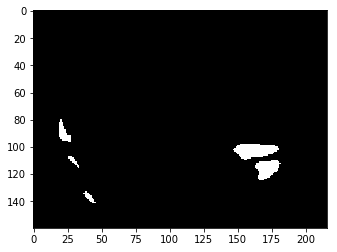

In [14]:
img = 10
matrix_pred[img] = np.array(matrix_pred[img])
plt.imshow(matrix_pred[img][:,0,:,0,0], cmap='gray')
plt.show()

In [ ]:
val_patch_size = 256
iteration = len(val_list) // val_patch_size
prev_time = time.clock()
correct = 0
for j in range(iteration):
    val_x, val_y = create_val_patch(val_patch_size, key = j)
    val_x, val_y = Variable(val_x.cuda(3)), val_y.cuda(3)
    #train
    #check accuracy
    val_pred = net.forward(val_x)
    val_pred = val_pred.view(-1, 5)
    _, predicted = torch.max(val_pred.data, 1)
    correct += (predicted == val_y).sum()
    total_test_size = val_patch_size * (j+1)
    if j % 10 == 0:
        print('iteration %d /%d:'%(j, iteration))
        print(float(j)/iteration,  'finished')
        print('Validation accuracy:', float(correct) / total_test_size)
        print('time used:%.3f'% (time.clock() - prev_time))

In [10]:
#cas-net test

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import torch.nn.init as ini
import multiprocessing
from multiprocessing import Queue
import random
from random import shuffle
import pickle

class InputCasNet(nn.Module):
    def __init__(self):
        super(InputCasNet, self).__init__()
        self.first_upper_layer1=nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.first_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.first_under_layer1=nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        
        self.first_final_layer=nn.Conv2d(224,5,21)
        
        self.second_upper_layer1=nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.second_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.second_under_layer1=self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        self.second_final_layer = nn.Conv2d(224,5,21)
    
    def forward(self, x1):
        upper_x=self.first_upper_layer2(self.first_upper_layer1(x1))
        under_x=self.first_under_layer1(x1)
        x=torch.cat((upper_x, under_x), 1)
        x=self.first_final_layer(x)
        x2=x1[:, :, 16:48+1, 16:48+1]*1.0
        x2=torch.cat((x, x2), 1)
        upper_x2=self.second_upper_layer2(self.second_upper_layer1(x2))
        under_x2=self.second_under_layer1(x2)
        x3=torch.cat((upper_x2, under_x2), 1)
        x3=self.second_final_layer(x3)
        return x3

cas_net=InputCasNet()
cas_net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
cas_net.cuda(0)

InputCasNet (
  (first_upper_layer1): Sequential (
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (first_upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (first_under_layer1): Sequential (
    (0): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
  )
  (first_final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
  (second_upper_layer1): Sequential (
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1)